In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

In [4]:
def plot_trend(x_axis, y_axis):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2006, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.show()

## Total number of death due to road traffic accidents in Finland

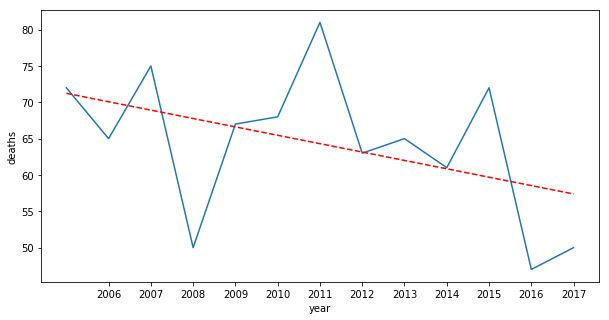

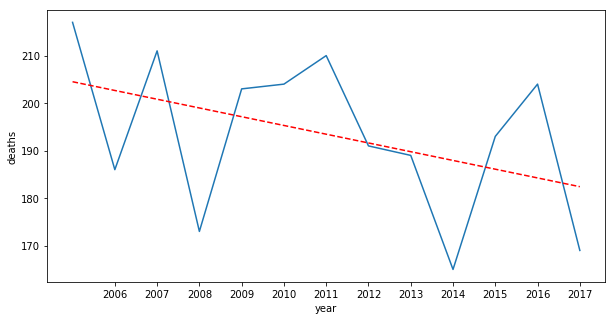

In [50]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
year_index = np.arange(1, len(years)+1)
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 14

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
num_groups = 2
x = np.arange(1, 3)
x = np.repeat(x, len(years))
N = len(total_deaths) * 2
combined = np.concatenate((male, female), axis=0)


plot_trend(years, female)
plot_trend(years, male)

In [65]:
# SEPARATE MODEL
accidents_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
    vector[N] years;

    }

    parameters {
        vector[K] a;
        vector[K] b;
        vector<lower=0>[K] sigma;
    }
    transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = a[x[i]] + b[x[i]]*years[i];
    }

    model {
      for (i in 1:N)
          number_of_deaths[i] ~ normal(mu[i], sigma[x[i]]);
    }

    generated quantities {
        real ypred;
        vector[N] log_lik;

        ypred = normal_rng(mu[2], sigma[2]);

        for (i in 1:N)
            log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[x[i]]);
    }
'''

accidents_data = {
        'N': N,
        'years': list(years)*2,
        'number_of_deaths': combined,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': num_groups,
        'x': x
    }

sm = pystan.StanModel(model_code = accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf2e93a6f54923a71fad4ffa61060da9 NOW.


In [66]:
separate_fit = sm.sampling(data = accidents_data,control = {'adapt_delta': 0.95, 'max_treedepth': 15})

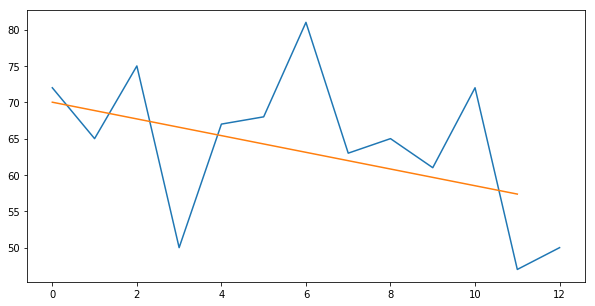

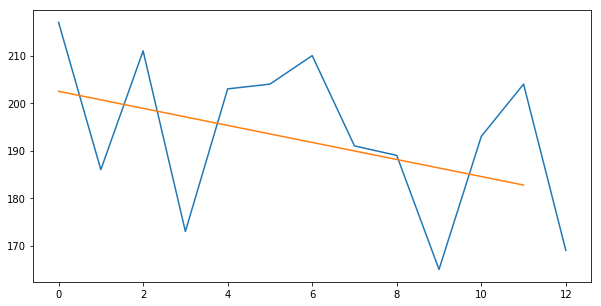

In [67]:
a = separate_fit.extract()['a']
b = separate_fit.extract()['b']
a = np.mean(a,axis=0)
b = np.mean(b,axis=0)
plt.plot(female)
plt.plot([a[1]+b[1]*i for i in range(2006,2018)])
plt.show()
plt.plot(male)
plt.plot([a[0]+b[0]*i for i in range(2006,2018)])

In [68]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -106.69197011701654
The effective number of parameters is: 4.971921606217521
K-hat values: [ 0.36732523  0.44895261  0.2603903   0.65047533  0.20137189  0.15536982
  0.20526621  0.14488892  0.14542057  0.54233948  0.14382009  0.34673153
  0.4917038   0.27463147  0.30260793  0.13306894  0.29608781  0.11708537
  0.04655388  0.33350081  0.08711862 -0.04147074 -0.02550865  0.35488951
  0.28322226  0.33553551]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a[1],3801.240572,73.215370,2692.503068,-1729.513416,2107.125678,3850.556422,5587.268396,8958.414011,1352.408492,1.001380
a[2],2375.504470,51.587389,1704.794457,-1166.034689,1345.223375,2358.750669,3448.122285,5848.822521,1092.086301,1.007429
b[1],-1.793992,0.036405,1.338867,-4.356657,-2.684094,-1.817092,-0.951493,0.957378,1352.518945,1.001381
b[2],-1.149298,0.025650,0.847730,-2.876668,-1.682608,-1.141128,-0.635831,0.612902,1092.288946,1.007428
sigma[1],17.710270,0.102865,4.301667,11.432942,14.747613,16.989076,19.912619,28.139957,1748.788788,1.001220
sigma[2],10.966166,0.076566,2.831207,7.017523,9.041054,10.407502,12.361121,18.011764,1367.338385,1.000068
mu[1],204.285769,0.236309,9.443740,184.854312,198.659638,204.497148,210.051184,222.774586,1597.085828,1.000945
mu[2],202.491776,0.202395,8.328530,185.314225,197.481636,202.691013,207.476685,218.921848,1693.309598,1.000848
mu[3],200.697784,0.169518,7.289015,185.567901,196.272443,200.856774,205.184356,215.094041,1848.873473,1.000722
mu[4],198.903792,0.138417,6.362404,185.645800,195.017035,199.011344,202.844607,211.303830,2112.830341,1.000564


In [34]:
# POOLED MODEL
pooled_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
    
    vector[13] year;
    
    real mean_data;
    real variance_data;
}

parameters {
    //real mu;             // prior mean
    real<lower=0> sigma;
    
    real alpha;
    real beta;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + beta*year;
}

model {
    
    //beta ~ normal(0, variance_data);

    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    
    ypred = normal_rng(alpha + (beta * 14), sigma);
    //ypred = normal_rng(mu, sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''


accidents_data = {
        'N': len(total_deaths),
        'year': year_index,
        'number_of_deaths': total_deaths,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': 1,
        'x': x
    }


sm = pystan.StanModel(model_code = pooled_factory_code)
pooled_fit = sm.sampling(data = accidents_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f11b8e44806b5c5dd4c389cc63eeef13 NOW.


In [32]:
summary = pooled_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = pooled_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -1037.4475714169898
The effective number of parameters is: 294.43069343099194
K-hat values: [4.1884868  1.65185508 3.46396873 4.99662968 1.492399   1.62132859
 4.61242346 1.66198369 1.66198369 4.46586806 1.50259898 1.65185508
 5.84578614]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
sigma,25.487306,0.178148,6.338738,16.603521,20.981922,24.527098,28.515824,41.208906,1266.035059,1.001534
alpha,279.159194,0.393979,15.107975,249.491814,269.354800,279.309766,288.676449,309.447254,1470.504507,1.001350
beta,-3.041985,0.050337,1.927493,-6.948702,-4.257800,-3.054626,-1.825456,0.822565,1466.276561,1.000784
mu[1],276.117208,0.346152,13.453848,249.862383,267.405949,276.222797,284.625350,303.064587,1510.638325,1.001420
mu[2],273.075223,0.299123,11.882408,249.730327,265.447278,273.230544,280.503731,296.742724,1578.005384,1.001499
mu[3],270.033237,0.253340,10.431091,249.523370,263.227102,270.070828,276.557420,290.901745,1695.321090,1.001581
mu[4],266.991252,0.209753,9.157192,248.687036,261.052417,267.093022,272.764569,285.173917,1905.929818,1.001649
mu[5],263.949266,0.169736,8.144393,247.538748,258.763339,264.027690,269.089109,280.224871,2302.351669,1.001664
mu[6],260.907281,0.136447,7.499238,245.443002,256.133980,261.015498,265.639689,275.774645,3020.680675,1.001569
mu[7],257.865295,0.115692,7.319594,242.842628,253.275653,258.041758,262.614073,272.003406,4002.806592,1.001342


In [164]:
# HIERARCHICAL MODEL
hierarchical_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
}

parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior 
    
    vector[K] mu;         // group means
    real<lower=0> sigma;
}

model {
    mu ~ normal(mu0, sigma0);
    number_of_deaths ~ normal(mu[x], sigma);
}

generated quantities {
    real mu3;
    real ypred;
    vector[N] log_lik;
    
    mu3 = normal_rng(mu0, sigma0);
    ypred = normal_rng(mu[2], sigma);
    
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[x[i]], sigma);    
}
'''


accidents_data = {
        'N': N,
        'year': years,
        'number_of_deaths': combined,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': num_groups,
        'x': x
    }


sm = pystan.StanModel(model_code = hierarchical_factory_code)
hierarchical_fit = sm.sampling(data = accidents_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4b648e9e9309fe2176fda48161fafe4 NOW.


In [165]:
summary = hierarchical_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = hierarchical_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -107.25441951882813
The effective number of parameters is: 2.5216634985764728
K-hat values: [ 0.00840963  0.02300535  0.05266991  0.32393447 -0.01097478 -0.017516
  0.04863637  0.07184699  0.03678806  0.4563215   0.06890817 -0.017516
  0.36911502  0.02049945  0.02744453  0.1259673   0.17598525  0.07247911
  0.07141031  0.21369146  0.10451994  0.02744453  0.10962256  0.02049945
  0.29025607  0.17598525]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,8.362804e+06,1.509622e+07,1.166573e+08,-9.760909e+07,-8.280941e+05,6.710579e+03,2.678104e+06,2.627165e+08,59.715533,1.078800
sigma0,3.240835e+08,9.607845e+07,2.777353e+09,1.210652e+04,3.646548e+05,4.053384e+06,5.094215e+07,1.871551e+09,835.622514,1.007450
mu[1],1.933227e+02,1.295081e-01,4.170009e+00,1.849818e+02,1.907234e+02,1.931519e+02,1.960888e+02,2.015668e+02,1036.764763,1.002787
mu[2],6.435724e+01,1.141250e-01,3.973076e+00,5.620089e+01,6.173542e+01,6.434755e+01,6.711158e+01,7.229673e+01,1211.970693,1.003056
sigma,1.466974e+01,7.168790e-02,2.313555e+00,1.098179e+01,1.307436e+01,1.434197e+01,1.593739e+01,1.984601e+01,1041.520992,1.004858
mu3,2.458257e+07,3.792513e+07,2.365418e+09,-5.811977e+08,-2.462573e+06,1.633856e+03,3.093147e+06,6.723655e+08,3890.109087,0.999399
ypred,6.404514e+01,2.693261e-01,1.524823e+01,3.404111e+01,5.397238e+01,6.411412e+01,7.413825e+01,9.404620e+01,3205.398937,1.000336
log_lik[1],-5.024414e+00,1.555775e-02,5.358410e-01,-6.273195e+00,-5.330612e+00,-4.961832e+00,-4.634858e+00,-4.180930e+00,1186.255565,1.001770
log_lik[2],-3.766357e+00,5.960215e-03,1.924814e-01,-4.195474e+00,-3.884456e+00,-3.748042e+00,-3.628742e+00,-3.437639e+00,1042.925949,1.001732
log_lik[3],-4.407746e+00,1.053038e-02,3.607164e-01,-5.265497e+00,-4.607154e+00,-4.374201e+00,-4.145644e+00,-3.825656e+00,1173.393122,1.002335


<h2>DON'T TOUCH</h2>

In [88]:
# POOLED MODEL
accidents_code = '''
data {
    int <lower=0> N;             //number of data points
    vector[N] year;              //observation year
    vector[N] number_of_deaths;  //total number of deaths
    real prediction_year;        //prediction year
    
    real mean_data;
    real variance_data;
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + (beta * year);
}

model {
    beta ~ normal(mean_data, variance_data);
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    real ypred;
    ypred = normal_rng(alpha + (beta * prediction_year), sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''
model = pystan.StanModel(model_code=accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08358f6ba04d909bf58b98a68905ca88 NOW.


In [92]:
def stan_sampling_fit(deaths, years, year_to_predict):
    accidents_data = {
        'N': len(deaths),
        'year': years,
        'number_of_deaths': deaths,
        'prediction_year': year_to_predict,
        'mean_data': mu,
        'variance_data': sigma
    }
    return model.sampling(data = accidents_data, control = {'adapt_delta': 0.95, 'max_treedepth': 15})

In [93]:
accidents_fit = stan_sampling_fit(total_deaths, years, prediction_year)
summary = accidents_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6204.828726,150.933996,3761.079796,-1137.273917,3724.947572,6222.663028,8537.739640,14237.816559,620.941881,1.004204
beta,-2.957289,0.075047,1.870205,-6.955245,-4.119105,-2.964891,-1.724260,0.690482,621.034706,1.004210
sigma,25.449274,0.241566,7.059479,16.195590,20.625374,24.201249,28.630868,42.000526,854.029137,1.008622
mu[1],275.465008,0.471963,13.554274,248.692233,267.050012,275.396564,283.770678,302.426057,824.776184,1.001645
mu[2],272.507719,0.399084,12.037588,248.487374,265.145242,272.470661,279.857875,296.495408,909.810198,1.001219
mu[3],269.550431,0.327143,10.634097,248.192885,262.965213,269.536479,275.879999,290.363102,1056.640027,1.000711
mu[4],266.593142,0.256015,9.394672,247.859487,260.758148,266.592878,272.160597,285.135122,1346.579830,1.000154
mu[5],263.635853,0.191304,8.392320,247.023526,258.594832,263.626682,268.642885,280.284559,1924.491041,0.999662
mu[6],260.678565,0.143466,7.719944,244.866378,255.982864,260.710746,265.215716,276.036490,2895.527759,0.999464
mu[7],257.721276,0.125316,7.467220,242.738338,253.151080,257.707949,262.298796,272.478411,3550.618252,0.999806


In [94]:
log_lik = accidents_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('KS value: {0}'.format(ks))

PSIS-LOO value: -1073.7430435979738
The effective number of parameters is: 334.2322711627885
KS value: [4.66699334 2.24970016 3.98836063 5.17580993 1.82651468 1.75728701
 4.84117662 2.23982191 2.23982191 4.84245416 2.30440344 2.24970016
 6.18708349]


#### Predictions for total number of deaths in 2018

In [7]:
def plot_perdiction_histogram(fit, xlim, xticks):
    y_pred = fit.extract()['ypred']
    plt.hist(y_pred, bins=40, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(xticks)
    plt.show()

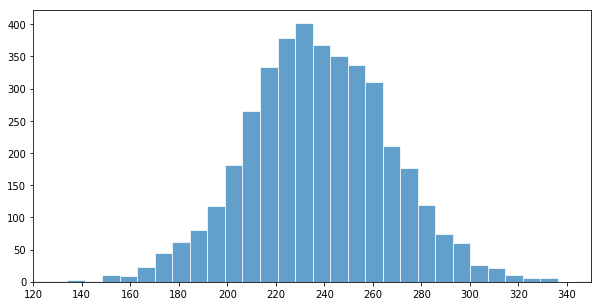

In [8]:
plot_perdiction_histogram(
    accidents_fit, 
    xlim=[120, 350], 
    xticks=np.arange(120, 360, 20)
)

## Male death due to road traffic accidents in Finland

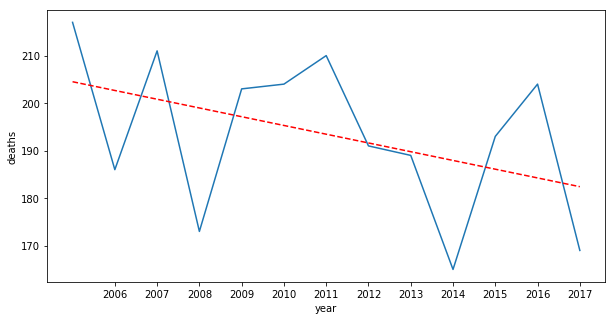

In [9]:
plot_trend(years, male)

In [10]:
accidents_fit_male = stan_sampling_fit(male, years, prediction_year)
summary_male = accidents_fit_male.summary()
summary_male = pd.DataFrame(
    summary_male['summary'], 
    columns=summary_male['summary_colnames'], 
    index=summary_male['summary_rownames']
)

summary_male

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3736.250993,270.587926,2750.995897,-2110.994679,2116.401739,3788.758163,5460.833686,8887.710308,103.362512,1.044950
beta,-1.761662,0.134560,1.367923,-4.322608,-2.619405,-1.787750,-0.957213,1.149628,103.346098,1.044971
sigma,17.836704,0.211912,4.064771,11.854207,14.954784,17.091811,19.968009,27.758148,367.927314,1.007070
mu[1],204.118739,0.808310,9.650606,184.950055,197.913631,204.212390,210.144261,223.399120,142.545366,1.028463
mu[2],202.357077,0.675166,8.502010,185.545988,196.975906,202.365261,207.706002,219.428880,158.570587,1.024852
mu[3],200.595415,0.539695,7.428095,185.847088,195.857289,200.593110,205.297422,215.907152,189.433812,1.020144
mu[4],198.833753,0.402152,6.466177,185.815099,194.698426,198.838796,202.852596,212.221036,258.532851,1.014250
mu[5],197.072091,0.261737,5.673511,185.562534,193.401814,197.120813,200.622534,208.841488,469.864318,1.007713
mu[6],195.310429,0.125091,5.129175,184.925765,191.919096,195.401362,198.567787,205.752075,1681.292874,1.002506
mu[7],193.548767,0.081908,4.916358,183.737766,190.388573,193.547988,196.687796,203.299586,3602.733112,1.001858


#### Predictions for number of male deaths in 2018

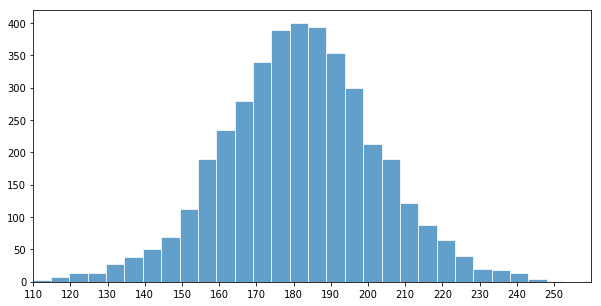

In [11]:
plot_perdiction_histogram(
    accidents_fit_male, 
    xlim=[110, 260], 
    xticks=np.arange(110, 260, 10)
)

## Female death due to road traffic accidents in Finland

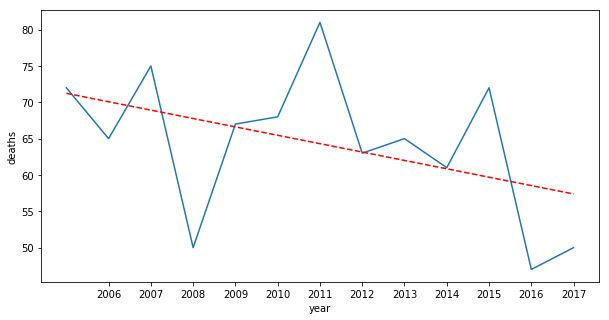

In [12]:
plot_trend(years, female)

In [13]:
accidents_fit_female = stan_sampling_fit(female, years, prediction_year)
summary_female = accidents_fit_female.summary()
summary_female = pd.DataFrame(
    summary_female['summary'], 
    columns=summary_female['summary_colnames'], 
    index=summary_female['summary_rownames']
)

summary_female

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,2369.248788,121.737375,1659.366637,-1089.514757,1329.222126,2362.730241,3410.785300,5631.628016,185.796206,1.040411
beta,-1.146139,0.060532,0.825172,-2.766537,-1.664266,-1.143387,-0.628378,0.573541,185.828958,1.040406
sigma,10.718313,0.182516,2.500732,7.212495,8.981616,10.273506,12.089514,17.055571,187.728615,1.031169
mu[1],71.240357,0.373633,5.744142,59.517981,67.750242,71.136040,74.879736,82.610444,236.352307,1.030057
mu[2],70.094218,0.313624,5.059485,59.728950,67.001327,69.991185,73.308051,80.194240,260.252455,1.026831
mu[3],68.948079,0.253844,4.423058,59.943728,66.276545,68.871593,71.761913,77.794675,303.607806,1.022365
mu[4],67.801941,0.194460,3.858796,60.109238,65.444816,67.694930,70.272976,75.488043,393.771817,1.016388
mu[5],66.655802,0.135742,3.402791,59.934296,64.567036,66.630162,68.822909,73.561486,628.412420,1.009172
mu[6],65.509663,0.079542,3.103141,59.318615,63.594122,65.467299,67.487240,71.799119,1521.997575,1.002420
mu[7],64.363524,0.047756,3.006958,58.303687,62.510099,64.353945,66.223512,70.485103,3964.571714,0.999319


### Predictions for number of female deaths in 2018

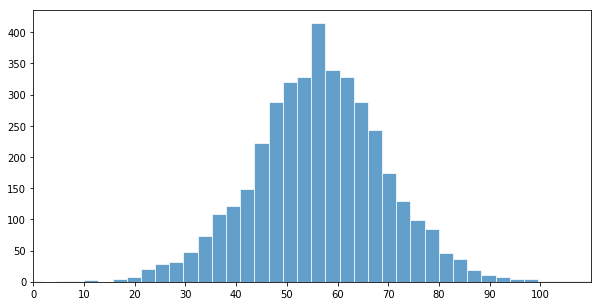

In [14]:
plot_perdiction_histogram(
    accidents_fit_female, 
    xlim=[0, 110], 
    xticks=np.arange(0, 110, 10)
)